In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import utils
import pickle
from scipy.stats import gaussian_kde
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 100
%load_ext autoreload
%autoreload 2


datapath = "data/climatic-zones-pv/"
figpath = "fig/"
savefig = False
if not os.path.isdir(figpath):
    os.mkdir(figpath)

In [2]:
# Use optimized angle for ICDF
df = pd.read_csv(datapath + "means-global.csv", skiprows=20)
# Drop self sufficiency; not needed for this notebook
df.drop("suff", axis = 1)

# Drop nans if any
# df.dropna(inplace = True)
# df.reset_index(inplace = True, drop = True)


# Compute weights according to latitude
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights

# Load icdfs
with open(datapath + "icdf-daily-G-global.pickle", "rb") as f:
    d = pickle.load(f)
    qs = d["quantiles"].copy()
    icdfs = d["icdf"]
    d = None # remove ref to d

In [3]:
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights
len(icdfs), len(df)

(1452132, 1452132)

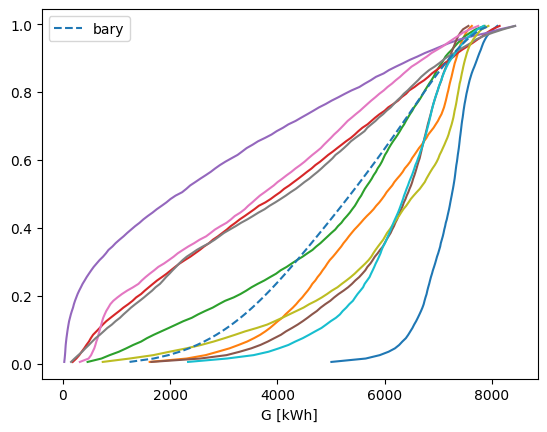

In [4]:
# Show some instances of icdf and plot barycenter
for i in np.random.choice(len(icdfs), 10):
    plt.plot(icdfs[i], qs)
# Compute weighted barycenter
#bary = np.average(icdfs, axis = 0)
bary = lat_weights.reshape(1, -1) @ icdfs /  lat_weights.sum()
bary = bary.ravel()
plt.plot(bary, qs, ls = "--", label = "bary")
plt.xlabel("G [kWh]")
plt.legend()
plt.show()

In [5]:
# Perform weighted PCA
A = (icdfs - bary.reshape(1, -1))
A *= lat_weights.reshape(-1, 1) # weight according to lat weights
U, s, Vh = np.linalg.svd(A, full_matrices=False)
# Rescale U so that we can recover the full original icdfs
U /= lat_weights.reshape(-1, 1)

In [6]:
# Change sign of some principal components for consistent interpretation
U[:,[2]] *= -1
Vh[[2],:]*= -1

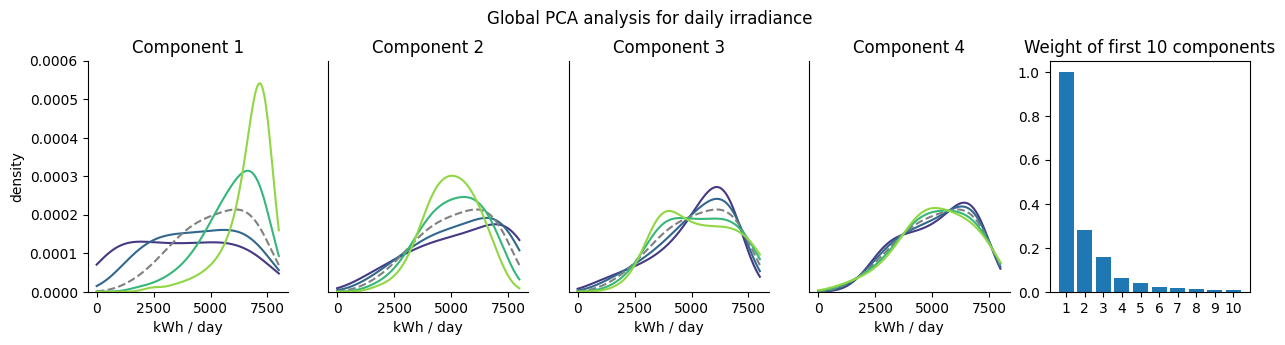

In [7]:
Ncomp = 4
density = True
x = np.linspace(0, 8000, 200)
cmap = plt.cm.viridis

fig, axs = plt.subplots(1, Ncomp+1, figsize = (15,3), dpi = 100)
for i in range(Ncomp):
    axs[i].spines[['right', 'top']].set_visible(False)

    v = Vh[i,:]
    # Change sign manually
    a = np.std(np.abs(U[:,i]*s[i]))
    for j, da in enumerate(np.linspace(-2, 2, 5)*a):
        ax = axs[i]
        z = bary + da*v
        if density: 
            kernel = gaussian_kde(z)
            y = kernel(x)
            kwargs = dict(color = cmap((da/a + 3)/6) )
            if da == 0:
                kwargs = dict(color = "gray", ls = "--")
            ax.plot(x,y,**kwargs)
            # ax.plot(z, qs,color = cmap((da/a + 3)/6), ls = "--" )
            ax.set_ylim([0,0.0006])

            axs[0].set_ylabel("density")
        else:
            ax.plot(z,qs, color = cmap((da/a + 3)/6))
            axs[0].set_ylabel("quantile")
        ax.set_xlabel("kWh / day")
        ax.set_title(f"Component {i+1}")
        if i > 0:
            ax.set_yticks([])
ax = axs[-1]

ax.bar(range(1,11), s[:10] / s[0])
ax.set_title("Weight of first 10 components")
ax.set_xticks(range(1,11))
plt.suptitle("Global PCA analysis for daily irradiance", y = 1.05)
if savefig: 
    plt.savefig(figpath + "principal-components-Gday.pdf", bbox_inches = "tight")

# Clustering in first 2 principal components

In [8]:
# Save first and second components in df, and downsample it
df["first"] = U[:, 0] * s[0]
df["second"] = U[:, 1] * s[1]

df_s = utils.subsample_df(df, 0.5)

In [9]:
# Set random seed for reproducibility
Ncomp = 2
np.random.seed(0)
Nclusters = 10
key = ["first", "second"]
dim = len(key)
# Renormalize subsampled data
datai_s = np.array(df_s[key])
scale = np.max(datai_s) 
datai_s = datai_s / scale

# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf

# Try KMeans several times and keep best
for i in tqdm(range(N_trials)):
    index_init = np.random.choice(len(df_s), Nclusters, replace = False)

    _, c, _ = utils.KMeans(datai_s, K = Nclusters, Niter = 20, index_init = index_init, 
                            weights = np.array(df_s.lat_weights),  p = 2)
    D_ij = ((datai_s.reshape(-1, 1, dim) -  c.reshape(1, -1, dim))** 2).sum(-1)
    score = D_ij.min(-1).sum()
    if score < best_score:
        best_score = score
        best_c = c

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Total representatives 2625
\begin{tabular}{rrrrr}
\toprule
class & lat & lon & 1st PC & 2nd PC \\
\midrule
1.000000 & 68.500000 & -46.100000 & -0.561000 & -0.472000 \\
2.000000 & 66.600000 & 67.800000 & -0.877000 & 0.067000 \\
3.000000 & 62.300000 & -97.600000 & -0.664000 & -0.022000 \\
4.000000 & 53.200000 & 70.900000 & -0.421000 & -0.058000 \\
5.000000 & 35.500000 & -83.200000 & -0.131000 & -0.083000 \\
6.000000 & -31.500000 & 126.400000 & 0.116000 & -0.115000 \\
7.000000 & 1.200000 & 109.100000 & -0.102000 & 0.199000 \\
8.000000 & -15.800000 & -58.500000 & 0.153000 & 0.083000 \\
9.000000 & 20.600000 & -102.900000 & 0.397000 & -0.043000 \\
10.000000 & 28.500000 & 41.000000 & 0.648000 & 0.027000 \\
\bottomrule
\end{tabular}



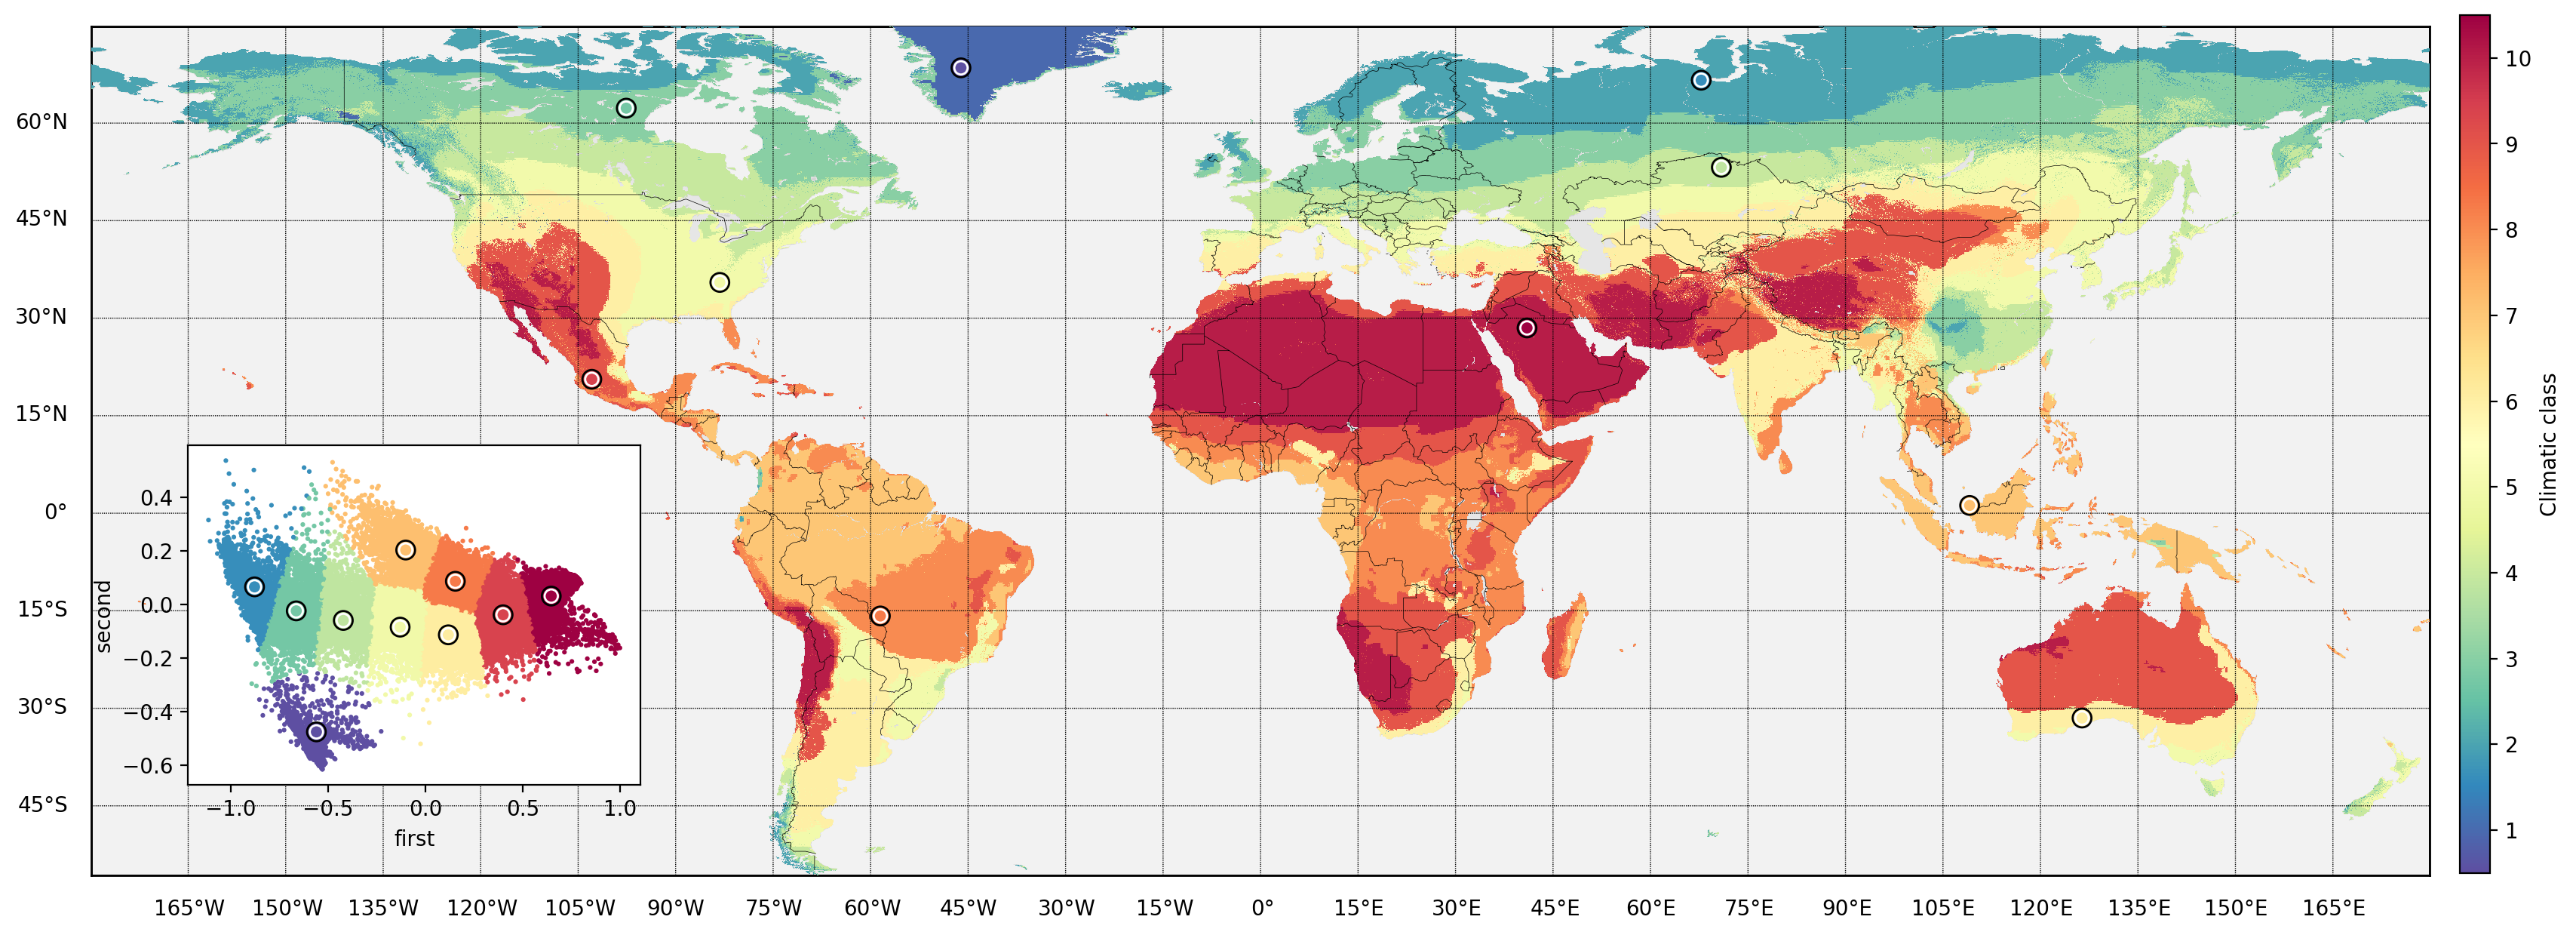

In [13]:
# Plotting part
figs = 20

write_tex_table = True
savefig = True

fig, ax = plt.subplots(figsize = (figs,figs*135/360), ncols = 1, dpi = 200)
ax.set_rasterization_zorder(3.5)

datai = np.array(df[key])
datai /= scale

c_id_sort = np.argsort(best_c @ np.array([1, 1.5]))
c = best_c[c_id_sort]

cl = ((datai.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 
ind = utils.random_representatives(datai, c, tol=0.005)

coords = df.lat.min(), df.lat.max(), df.lon.min(), df.lon.max()
ax = utils.drawmap(ax, coords, projection = "cyl", step_grid = 15)

# cmap = "Spectral_r"
cmap = mpl.colormaps["Spectral_r"]
# cmap = "turbo"
clim = (0,1)
img,extent = utils.rasterize(df.lat, df.lon, cl+1)
ims = plt.imshow(img, origin = "lower", cmap = cmap, extent = extent,
        interpolation = "nearest", zorder = 3, clim = (0.5, Nclusters+0.5))

# Show centroids on map

ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (0, Nclusters-1), zorder = 100)
ax.scatter(df.lon[ind], df.lat[ind], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (0, Nclusters-1), zorder = 200)

if write_tex_table:
    # Create a df
    df_c = np.hstack((
        np.arange(10).reshape(-1, 1)+1,
        np.array(df.lat[ind]).reshape(-1, 1),
        np.array(df.lon[ind]).reshape(-1, 1),
        datai[ind.astype(np.int64)],
        ))
    df_c = pd.DataFrame(np.round(df_c,3), columns = ["class", "lat", "lon", "1st PC", "2nd PC"])
    s = df_c.to_latex(index = False)
    s = s.replace(".0 &", " &") 
    with open(figpath + "centroids_icdf.tex", "w") as f:
        f.write(s)
        print(s)

subax = fig.add_axes([0.157,0.20,0.15, 0.3])

cl_s = ((datai_s.reshape(-1, 1, dim) - c.reshape(1, -1, dim))**2).sum(-1).argmin(axis=1).reshape(-1) 

subax.scatter(datai_s[:,0], datai_s[:,1], c = cl_s, s = 5, cmap = cmap, edgecolor = "none")
subax.set_xlabel("first")
subax.set_ylabel("second")

subax.scatter(c[:,0], c[:,1], c = np.arange(Nclusters), marker = "o", edgecolor = "k", linewidth = 1, cmap = cmap, s = 80, clim = (0, Nclusters-1))
subax.scatter(c[:,0], c[:,1], c = np.arange(Nclusters), marker = "o", edgecolor = "w", linewidth = 1, cmap = cmap, s = 40, clim = (0, Nclusters-1))
# subax.legend(markerscale = 2, loc = (0,1.1), title = "Cluster id")

# Classification bar
clax = fig.add_axes((0.91,0.122, 0.01, 0.758))
plt.colorbar(ims, cax = clax)
clax.set_ylabel("Climatic class")
clax.set_yticks(np.arange(1,Nclusters+1))

if savefig:
    plt.savefig(figpath + f"clustering-icdf-Nclusters-{Nclusters}-Ncomp-{Ncomp}.pdf", bbox_inches = "tight")

plt.show()


